In [ ]:
!pip install TensorFlow
!pip install Keras
!pip install pillow
!pip install NumPy
!pip install tqdm
!pip install jupyterlab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/flikr30/newflickr30.zip"

In [ ]:
import csv
csv_file = '/content/flickr30k_images/results.csv'
txt_file = '/content/flickr30k_images/description.txt'
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [2]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer #for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.python.keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

<ipython-input-2-821f60623236>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [ ]:
file = open("/content/description.txt", 'r')
text = file.read()
file.close()

f = open("train.txt", "w")
for line in text.split("\n")[:-1]:
  l=line.split("|")
  f.write(l[0]+"\n")
f.close()
    


In [ ]:
file = open("/content/description.txt", 'r')
text = file.read()
file.close()

#f = open("train.txt", "w")
f = open("captions.txt", "w")
for line in text.split("\n")[:-1]:
  l=line.split("|")
  print(len(l))
  final=l[0]+","+l[2][1:]
  f.write(final+"\n")
f.close()
     



In [3]:
# Load the document file into memory
def load_doc(filename):
  # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
# get all images with their captions
def img_capt(filename):
    file = load_doc(filename)
    descriptions ={}
    for caption in file.split("\n")[:-1]:
        caption = caption.split(',')
        img=caption[0]
        caption=caption[1]
        if img not in descriptions:
            descriptions[img] = [ caption ]
        else:
            descriptions[img].append(caption)
    return descriptions
#Data cleaning function will convert all upper case alphabets to lowercase, removing punctuations and words containing numbers
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            descp = img_caption.split()
          #uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
          #remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
          #remove hanging 's and a
            descp = [wrd for wrd in descp if(len(wrd)>1)]
          #remove words containing numbers with them
            descp = [wrd for wrd in descp if(wrd.isalpha())]
          #converting back to string
        img_caption = ' '.join(descp)
        captions[img][i]= img_caption
    return captions
def txt_vocab(descriptions):
  # To build vocab of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab
#To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
            data = "\n".join(lines)
            file = open(filename,"w")
            file.write(data)
            file.close()
# Set these path according to project folder in you system, like i create a folder with my name shikha inside D-drive
dataset_text = "/content/drive/MyDrive/ML/train (1).txt"
dataset_images = "/content/flickr30k_images"
#to prepare our text data
filename = "/content/drive/MyDrive/ML/captions (1).txt"
#loading the file that contains all data
#map them into descriptions dictionary 
descriptions = img_capt(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = txt_clean(descriptions)
#to build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving all descriptions in one file
#save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 31783
Length of vocabulary =  23445


In [4]:
print(len(clean_descriptions))

31783


In [ ]:
save_descriptions(clean_descriptions, "descriptions.txt")

In [ ]:
model = Xception( include_top=False, pooling='avg')

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
def extract_features(directory):
    model = Xception( include_top=False, pooling='avg' )
    features = {}
    for pic in tqdm(os.listdir(directory)):
        file = directory + "/" + pic
        image = Image.open(file)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
          #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        features[pic] = feature
    return features
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))
#to directly load the features from the pickle file.
#features = load(open("features.p","rb"))

In [ ]:
''''file = open("/home/vaishnavi/Documents/ML/Flickr8k_text/Flickr_8k.trainImages.txt", 'r')
text = file.read()
file.close()
f = open("myfile.txt", "w")

for line in text.split("\n")[:-1]:
    f.write("/home/vaishnavi/Documents/ML/Flickr8k_Dataset/Flicker8k_Dataset/"+line+"\n")
    
f.close()'''

In [5]:
features = load(open("/content/drive/MyDrive/ML/features (1).p","rb"))
#features

In [6]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/MyDrive/ML/features (1).p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


filename = "/content/drive/MyDrive/ML/train (1).txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("/content/drive/MyDrive/ML/descriptions (1).txt", train_imgs)
train_features = load_features(train_imgs)

In [7]:
print(len(train_descriptions))
print(len(train_imgs))
print(len(train_features))

31783
158915
31783


In [ ]:
f = open("/content/drive/MyDrive/ML/myfile.txt", "w")
f.write("hi")
    
f.close()

In [ ]:
train_descriptions

In [ ]:
all_features = load(open("/home/vaishnavi/Documents/ML/features.p","rb"))
all_features["/home/vaishnavi/Documents/ML/Flickr8k_Dataset/Flicker8k_Dataset/667626_18933d713e.jpg"]

In [8]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size
#calculate maximum length of descriptions to decide the model structure parameters.
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

79

In [9]:
tokenizer=load(open("tokenizer.p","rb"))
tokenizer

In [ ]:
vocab_size

18479

In [ ]:
#file = open("/home/vaishnavi/Documents/ML/descriptions.txt", 'r')
text = file.read()
file.close()

f = open("description1.txt", "w")

for line in text.split("\n")[:-1]:
    f.write("/home/vaishnavi/Documents/ML/Flickr8k_Dataset/Flicker8k_Dataset/"+line+"\n")
    
#f.close()

In [10]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((56, 2048), (56, 79), (56, 18479))

In [11]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("/content/drive/MyDrive/flikr30/model_" + str(i) + ".h5")

Dataset:  158915
Descriptions: train= 31783
Photos: train= 31783
Vocabulary Size: 18479
Description Length:  79
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 79)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 79, 256)      4730624     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]'

<ipython-input-12-eeb47c42639d>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


12130/31783 [==========>...................] - ETA: 1:16:40 - loss: 3.5686

In [ ]:
!pip install matplotlib

1/1 [==============================] - 1s 1s/step
nn
start a man hikes up a snowy mountain end


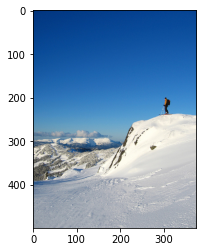

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
#ap = argparse.ArgumentParser()
#ap.add_argument('-i', '--image', required=True, help="Image Path")
#args = vars(ap.parse_args())
img_path = "/content/Flickr8k_Dataset/Flicker8k_Dataset/106514190_bae200f463.jpg"
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
      # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('/content/models/model_19.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 596ms/step
nn
start a man is climbing a rock face end


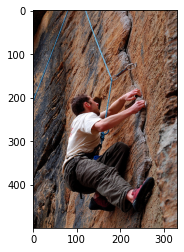

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
#ap = argparse.ArgumentParser()
#ap.add_argument('-i', '--image', required=True, help="Image Path")
#args = vars(ap.parse_args())
img_path = "/content/Flickr8k_Dataset/Flicker8k_Dataset/111537217_082a4ba060.jpg"
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
      # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('/content/models/model_19.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 595ms/step
nn
start a baby is playing with a toy end


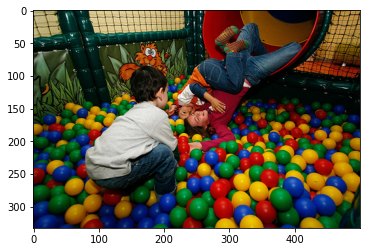

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
#ap = argparse.ArgumentParser()
#ap.add_argument('-i', '--image', required=True, help="Image Path")
#args = vars(ap.parse_args())
img_path = "/content/Flickr8k_Dataset/Flicker8k_Dataset/1925434818_2949a8f6d8.jpg"
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
      # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('/content/models/model_19.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 599ms/step
nn
start a man is sitting on a rocky peak overlooking a mountain end


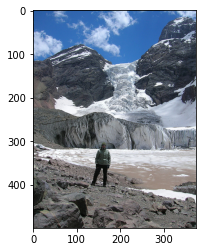

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
#ap = argparse.ArgumentParser()
#ap.add_argument('-i', '--image', required=True, help="Image Path")
#args = vars(ap.parse_args())
img_path = "/content/Flickr8k_Dataset/Flicker8k_Dataset/2097403787_77a154f5b9.jpg"
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
      # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('/content/models/model_19.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)

1/1 [==============================] - 1s 1s/step
nn
start a man in a black hat is riding a red atv end


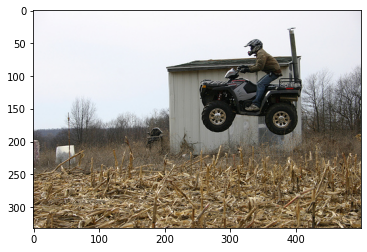

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
#ap = argparse.ArgumentParser()
#ap.add_argument('-i', '--image', required=True, help="Image Path")
#args = vars(ap.parse_args())
img_path = "/content/Flickr8k_Dataset/Flicker8k_Dataset/109823397_e35154645f.jpg"
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
      # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('/content/drive/MyDrive/ML/model_19.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)

1/1 [==============================] - 2s 2s/step
nn
start a woman in a pink dress is dancing with a man in a blue shirt end


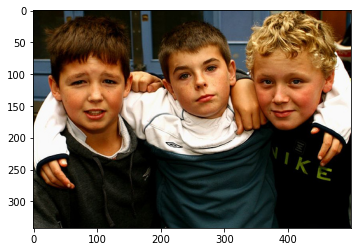

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
#ap = argparse.ArgumentParser()
#ap.add_argument('-i', '--image', required=True, help="Image Path")
#args = vars(ap.parse_args())
img_path = "/content/Flickr8k_Dataset/Flicker8k_Dataset/2075493556_b763648389.jpg"
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
      # for 4 channels images, we need to convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('/content/drive/MyDrive/ML/model_19.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("nn")
print(description)
plt.imshow(img)